In [1]:
from DPC import DPCModel
from FLORIS_PT import FLORIS_PT
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors
plt.rcParams.update({'font.size': 16})

## FLORIS-PT and DPC

### Shared inputs

In [2]:
# input files to define turbine type, wind conditions, and FLORIS model parameters
input_file_path = "./inputs.yaml"
floris_pt = FLORIS_PT(input_file_path)

# wind farm layout
D = floris_pt.turbine['rotor_diameter']
x_coord = torch.tensor([0., 6.*D,
                        0., 6.*D])
y_coord = torch.tensor([3.*D, 3.*D, 
                        0., 0.])
z_hh = floris_pt.turbine['hub_height']
nturbs = len(x_coord)
z_coord = torch.tensor([z_hh] * nturbs)

## FLORIS-PT

### FLORIS-PT inputs

In [3]:
wd = torch.tensor([270.]) # degrees
ws = torch.tensor([8.0]) # m/s
u = torch.tensor([25., 0., 25., 0.]) # yaw angles for each turbine in farm

### Power and velocity given control action

In [4]:
# generate mesh on turbine rotor
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

# calculate field on rotor mesh
u_rotated = u[inds_sorted]
flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, u_rotated, \
    x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)

# calculate turbine power
p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)

# print individual turbine power, farm power, and velocity
print("turbine power: ", np.round(p.detach().numpy().flatten(), 0)) # kW
print("farm power: ", np.round(torch.sum(p).detach().numpy(), 0)) # kW
print("velocity: ", flow_field_u.detach().numpy()[0, 0, 0, :, :, :]) # m/s

turbine power:  [1406. 1406.  925.  925.]
farm power:  4662.0
velocity:  [[[7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]]

 [[7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]
  [7.596956  8.        8.293351 ]]

 [[5.5026693 5.279379  6.0070868]
  [6.21089   6.199405  6.7802277]
  [7.0419436 7.279001  7.6874623]]

 [[5.5026693 5.279379  6.0070868]
  [6.21089   6.199405  6.7802277]
  [7.0419436 7.279001  7.6874623]]]


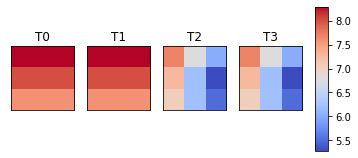

In [5]:
# plotting settings
t_range = None
wd_index = 0
ws_index = 0
n_rows = 1
n_cols = 4
cmap = "coolwarm"
save_path = False

#plot rotor values
cmap = plt.cm.get_cmap(name=cmap)
if t_range is None:
    t_range = range(flow_field_u.shape[3])
    
fig = plt.figure()
axes = fig.subplots(n_rows, n_cols)

indices = t_range
titles = np.array([f"T{i}" for i in indices])

for ax, t, i in zip(axes.flatten(), titles, indices):
    vmin = torch.min(flow_field_u[wd_index, ws_index])
    vmax = torch.max(flow_field_u[wd_index, ws_index])

    bounds = np.linspace(vmin, vmax, 31)
    norm = mplcolors.Normalize(vmin, vmax)

    ax.imshow(flow_field_u[0, wd_index, ws_index, i].T, cmap=cmap, norm=norm, origin="lower")
    ax.invert_xaxis()

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.03, 0.5])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

plt.show()

## DPC

### Helper functions to apply DPC to FLORIS-PT

In [6]:
# get control action from DPC model
def get_control(model, ws, wd, inds_sorted, ws_max, wd_max=360.):
    # normalize features to range [0,1] by dividing ws by ws_max and wd by wd_max
    x = torch.cat([ws/ws_max, wd/wd_max])
    u = model(x)
#     clipped_u = F.relu(u*umax-umin) + umin
#     clipped_u = -F.relu(-clipped_u + umax) + umax
    clipped_u = u*umax
    clipped_u = clipped_u[inds_sorted.flatten()]
    return u, clipped_u

# calculate average power over list of wind speeds
# modifies powers list to add this average power
def test_power(floris_pt, model, ws_all, wd, powers, x_coord, y_coord, z_coord, \
               ws_max, wd_max=360.):
    
    # generate mesh on turbine rotor
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
    
    # calculate avg power over wind speeds
    power = 0.
    for ws in ws_all:
        # get control action
        u, clipped_u = get_control(model, ws, wd, inds_sorted, ws_max, wd_max)
        
        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u, \
            x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)
        
        # add farm power
        power += torch.sum(p)
    power /= len(ws_all)
    powers.append(float(power.detach().numpy()))

###  DPC inputs

In [7]:
# set bounds on allowed yaw angle
umin = torch.tensor([0.]) # minimum allowed yaw angle (degrees)
umax = torch.tensor([25.]) # maximum allowed yaw angle (degrees)

# neural network parameters
model_config = dict({"n_turbines": nturbs, 
                     "hidden_dim": 64})

# hyperparameters
lambda_ = 100. # scaling constant for penalty on constraint violations
lr = .001
batch_size = 20
N_batches = 10
N_epochs = 10

# generate training data
ws_max = 8.0
wd_fixed = 270.
ws_training = torch.rand((N_batches, batch_size, 1)) * ws_max # ws from [0, ws_max]; m/s
wd_training = wd_fixed + .1*(torch.rand((N_batches, batch_size, 1)) -.5) # wd varies around wd_fixed; degrees

# pick validation set
ws_validation = torch.tensor([[4.], [6.], [8.]]) # m/s
wd_validation = torch.tensor([270.]) # degrees

### Training

In [8]:
# initialize DPC model
model = DPCModel(**model_config)

# initialize optimizer used for training
opt = torch.optim.Adam(model.parameters(), lr=lr)

# vectors to track training progress
opt_losses = []
u_viol_losses = []
power_losses = []
powers_validation = []

# calculate and record power over validation set 
# using control actions from untrained DPC policy
test_power(floris_pt, model, ws_validation, wd_validation, powers_validation, \
           x_coord, y_coord, z_coord, ws_max)

for epoch in range(N_epochs):
    print("epoch: %d/%d."%(epoch+1,N_epochs))
    for batch in range(N_batches):
        opt_loss = 0.
        u_viol_loss = 0.
        power_loss = 0.

        # forward pass
        for sample in range(batch_size):
            ws = ws_training[batch, sample]
            wd = wd_training[batch, sample]

            # generate mesh on turbine rotor
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
                floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

            # get control action
            u, clipped_u = get_control(model, ws, wd, inds_sorted, ws_max)

            # calculate field on rotor mesh
            flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, clipped_u, \
                x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted)

            # calculate turbine power
            p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)

            # negative farm power (negative b/c optimizer minimizes loss)
            power_cost = -torch.sum(p)

            # cost from soft constraints (violating bounds on yaw angle)
            u_viol_lower = F.relu(umin - u*umax)
            u_viol_upper = F.relu(u*umax - umax)
            u_viol_cost = lambda_ * torch.sum(torch.sqrt(u_viol_lower.pow(2) + u_viol_upper.pow(2) +1e-16))

            # total cost
            total_cost = u_viol_cost + power_cost

            # sum over samples in batch
            opt_loss += total_cost
            u_viol_loss += u_viol_cost
            power_loss += power_cost

        # normalize loss by batch size
        opt_loss /= batch_size
        u_viol_loss /= batch_size
        power_loss /= batch_size

        # backward pass
        opt.zero_grad()
        opt_loss.backward()
        opt.step()
        
        # save losses
        opt_losses.append(opt_loss.detach().numpy())
        u_viol_losses.append(u_viol_loss.detach().numpy())
        power_losses.append(power_loss.detach().numpy())

        # calculate and record power over validation set 
        # using control actions from updated DPC policy
        test_power(floris_pt, model, ws_validation, wd_validation, powers_validation, \
               x_coord, y_coord, z_coord, ws_max)

epoch: 1/10.
epoch: 2/10.
epoch: 3/10.
epoch: 4/10.
epoch: 5/10.
epoch: 6/10.
epoch: 7/10.
epoch: 8/10.
epoch: 9/10.
epoch: 10/10.


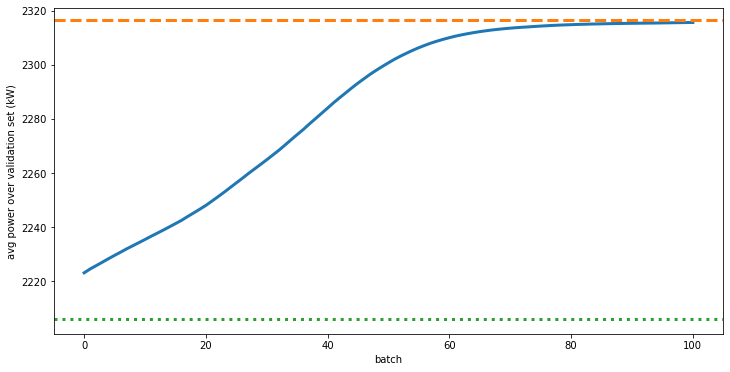

In [9]:
# power for validation set from FLORIS model (baseline and optimized)
FLORIS_baseline = (4483. + 1771. + 364.)/3. # unyawed; from FLORIS
FLORIS_opt = (4662. + 1882. + 406.)/3. # optimal yaw; from FLORIS

plt.plot(np.array(powers_validation), label='DPC', color='tab:blue', linestyle='-', linewidth=3)
plt.axhline(FLORIS_baseline, label='baseline', color='tab:green', linestyle=':', linewidth=3)
plt.axhline(FLORIS_opt, label='lookup table', color='tab:orange', linestyle='--', linewidth=3)
plt.xlabel('batch')
plt.ylabel('avg power over validation set (kW)')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

### Testing

In [10]:
ws = torch.tensor([ws_max])
wd = torch.tensor([wd_fixed])

# generate mesh on turbine rotor
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

# get control action
u_DPC, u_clipped_DPC = get_control(model, ws, wd, inds_sorted, ws_max)
u_optimal = torch.tensor([25., 0., 25., 0.])[inds_sorted] # optimal yaw; from FLORIS
u_baseline = torch.tensor([0., 0., 0., 0.])[inds_sorted] # unyawed

# compare DPC control action to optimal action (from FLORIS) 
# and baseline action (unyawed)
us = [u_clipped_DPC, u_optimal, u_baseline]
labels = ["DPC", "optimal", "baseline"]
for i in range(len(us)):    
    u = us[i]
    # calculate field on rotor mesh
    flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, wd, u, \
        x_coord_active, x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted)

    # calculate turbine power
    p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle)
    
    label = labels[i]
    print(label + " yaw: ", np.round(u.detach().numpy().flatten(),1))
    print(label + " power: ", np.round(torch.sum(p).detach().numpy(), 1))
    print("")

DPC yaw:  [24.5 24.8  0.8  1. ]
DPC power:  4660.5

optimal yaw:  [25. 25.  0.  0.]
optimal power:  4662.3

baseline yaw:  [0. 0. 0. 0.]
baseline power:  4483.0

